In [1]:
import pandas as pd
import numpy as np
import warnings
from xgboost import XGBRegressor
from utils import utils_gn, utils_sevsn, utils_noah, utils_models
import importlib
importlib.reload(utils_gn)
importlib.reload(utils_sevsn)
importlib.reload(utils_noah)
importlib.reload(utils_models)
warnings.filterwarnings('ignore')

In [2]:
# read the data
df_raw = (utils_gn.read_data('severson_all.pkl')).drop('cycle_life', axis=1).join(utils_gn.read_data('noah_all.pkl'))
df = df_raw.copy()
df.head()

,mean_Q_100_10,log_mean_Q_100_10,var_Q_100_10,log_var_Q_100_10,min_Q_100_10,log_min_Q_100_10,skew_Q_100_10,log_skew_Q_100_10,kurt_Q_100_10,log_kurt_Q_100_10,...,dVdQpeak_maxmag_di_y_100m0,dVdQpeak_maxmag_di_y_diff,dVdQpeak_maxarea_di_y_0,dVdQpeak_maxarea_di_y_50,dVdQpeak_maxarea_di_y_100,dVdQpeak_maxarea_di_y_100m0,dVdQpeak_maxarea_di_y_diff,dSOHdCycCyc1,dSOHdCycCyc100,cycle_life
b1c0,-0.002873,-2.541602,0.000010,-5.014861,-0.008460,-2.072648,-0.532058,-0.274041,1.651688,0.217928,...,-0.005282,0.003144,-79.299389,-75.009448,-68.133388,11.166000,2.586119,0.000388,-0.000031,1851.0
b1c1,-0.004100,-2.387257,0.000010,-5.013960,-0.011004,-1.958457,-0.429375,-0.367163,1.970884,0.294661,...,0.001686,0.000501,-75.511329,-73.411862,-60.405989,15.105340,10.906407,0.000396,-0.000019,2159.0
b1c2,-0.004487,-2.348070,0.000018,-4.737000,-0.017216,-1.764058,-1.080194,0.033502,3.348637,0.524868,...,-0.005399,0.004043,-76.601709,-73.345940,-65.414446,11.187263,4.675725,0.000312,-0.000013,2236.0
b1c3,-0.007456,-2.127507,0.000036,-4.442613,-0.018961,-1.722149,-0.439050,-0.357486,1.904584,0.279800,...,-0.002219,0.012165,-80.446334,-67.731448,-55.749502,24.696832,-0.732940,0.000353,-0.000013,1433.0
b1c4,-0.005750,-2.240332,0.000023,-4.647744,-0.013958,-1.855177,-0.362548,-0.440634,1.666169,0.221719,...,0.002736,0.001597,-75.575598,-65.232594,-55.730088,19.845510,-0.840498,0.000347,-0.000030,1708.0


In [3]:
df.index

Index(['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4', 'b1c5', 'b1c6', 'b1c7', 'b1c9',
       'b1c11',
       ...
       'b3c33', 'b3c34', 'b3c35', 'b3c36', 'b3c40', 'b3c41', 'b3c42', 'b3c43',
       'b3c44', 'b3c45'],
      dtype='object', length=124)

In [4]:
df.columns

Index(['mean_Q_100_10', 'log_mean_Q_100_10', 'var_Q_100_10',
       'log_var_Q_100_10', 'min_Q_100_10', 'log_min_Q_100_10', 'skew_Q_100_10',
       'log_skew_Q_100_10', 'kurt_Q_100_10', 'log_kurt_Q_100_10',
       ...
       'dVdQpeak_maxmag_di_y_100m0', 'dVdQpeak_maxmag_di_y_diff',
       'dVdQpeak_maxarea_di_y_0', 'dVdQpeak_maxarea_di_y_50',
       'dVdQpeak_maxarea_di_y_100', 'dVdQpeak_maxarea_di_y_100m0',
       'dVdQpeak_maxarea_di_y_diff', 'dSOHdCycCyc1', 'dSOHdCycCyc100',
       'cycle_life'],
      dtype='object', length=245)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 124 entries, b1c0 to b3c45
Columns: 245 entries, mean_Q_100_10 to cycle_life
dtypes: float64(245)
memory usage: 242.4+ KB


In [6]:
df.describe()

,mean_Q_100_10,log_mean_Q_100_10,var_Q_100_10,log_var_Q_100_10,min_Q_100_10,log_min_Q_100_10,skew_Q_100_10,log_skew_Q_100_10,kurt_Q_100_10,log_kurt_Q_100_10,...,dVdQpeak_maxmag_di_y_100m0,dVdQpeak_maxmag_di_y_diff,dVdQpeak_maxarea_di_y_0,dVdQpeak_maxarea_di_y_50,dVdQpeak_maxarea_di_y_100,dVdQpeak_maxarea_di_y_100m0,dVdQpeak_maxarea_di_y_diff,dSOHdCycCyc1,dSOHdCycCyc100,cycle_life
count,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,...,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000
mean,-0.018901,-1.795793,0.000223,-3.835354,-0.040760,-1.440500,-0.103301,-0.777828,1.857125,0.261912,...,-0.000860,0.006225,-86.421878,-61.174991,-46.747626,40.011316,-11.308809,0.000265,-0.000069,807.241935
std,0.011347,0.270904,0.000262,0.411134,0.020373,0.217995,0.330102,0.425974,0.454478,0.067593,...,0.046542,0.046324,11.467643,12.863652,6.312352,9.989366,20.046688,0.000136,0.000137,364.359118
min,-0.077684,-3.105396,0.000010,-5.014861,-0.138026,-2.251053,-1.080194,-2.337813,1.612805,0.207582,...,-0.040421,-0.052170,-112.994264,-88.677648,-69.014721,0.491715,-85.815278,-0.000126,-0.001108,170.000000
25%,-0.024233,-1.950487,0.000077,-4.114970,-0.052091,-1.573442,-0.285918,-0.976312,1.710361,0.233088,...,-0.008152,-0.002622,-92.562247,-71.707141,-48.543997,36.915481,-26.371329,0.000190,-0.000065,525.750000
50%,-0.017671,-1.752752,0.000168,-3.775169,-0.038753,-1.411715,-0.141639,-0.713148,1.761561,0.245898,...,-0.005461,0.001079,-86.660594,-59.687399,-44.930027,41.479825,-6.326848,0.000246,-0.000038,743.000000
75%,-0.011208,-1.615590,0.000298,-3.526121,-0.026703,-1.283235,-0.001193,-0.472983,1.866319,0.270984,...,-0.002174,0.005336,-82.555981,-50.581414,-42.971080,46.361411,4.678101,0.000336,-0.000025,945.500000
max,0.000785,-1.109668,0.001875,-2.726901,-0.005610,-0.860038,1.986572,0.298104,5.920243,0.772340,...,0.491715,0.491715,0.491715,-21.537204,-30.971796,61.613879,23.552556,0.000990,0.000211,2236.000000


In [7]:
# prune cells with more than 1250 cycle life
df = df[df['cycle_life'] <= 1250]
df.index

Index(['b1c5', 'b1c6', 'b1c7', 'b1c9', 'b1c11', 'b1c14', 'b1c15', 'b1c16',
       'b1c17', 'b1c18',
       ...
       'b3c29', 'b3c30', 'b3c31', 'b3c34', 'b3c35', 'b3c36', 'b3c40', 'b3c41',
       'b3c43', 'b3c44'],
      dtype='object', length=113)

In [8]:
# define paramters to use
test_size= 0.2
params= {"n_estimators": 500,
        "max_depth": 2,
        "min_samples_split": 5,
        "learning_rate": 0.01,
        "loss": "reg:linear"}

### XGBoost regression without scaling and feature selection

Tree-based regression has started...
Tree-based regression has ended after 1.74 seconds
------------------
Model metrics:
------------------
Train:
{'MAE': 16.301131523980036,
 'MAPE': 0.024247610714183555,
 'MSE': 451.35014027455406,
 'R2 score': 0.9901096658749142,
 'RMSE': 21.245002712980625}
Test:
{'MAE': 57.084064649498984,
 'MAPE': 0.08273140108519396,
 'MSE': 5466.779243898142,
 'R2 score': 0.9001028421182511,
 'RMSE': 73.93767134484385}


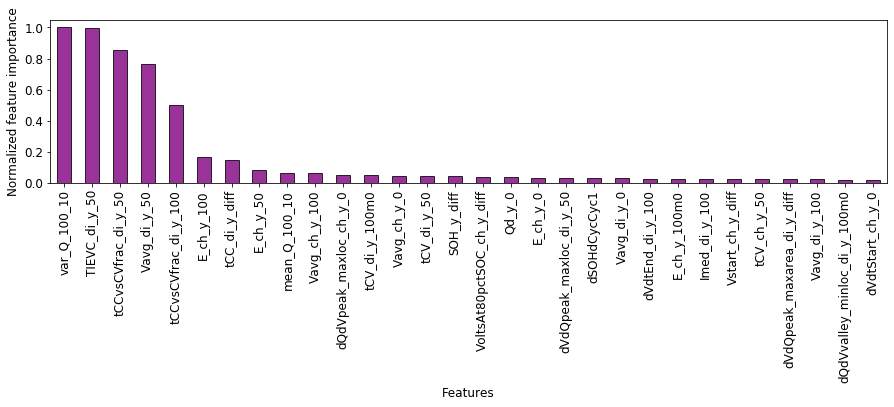

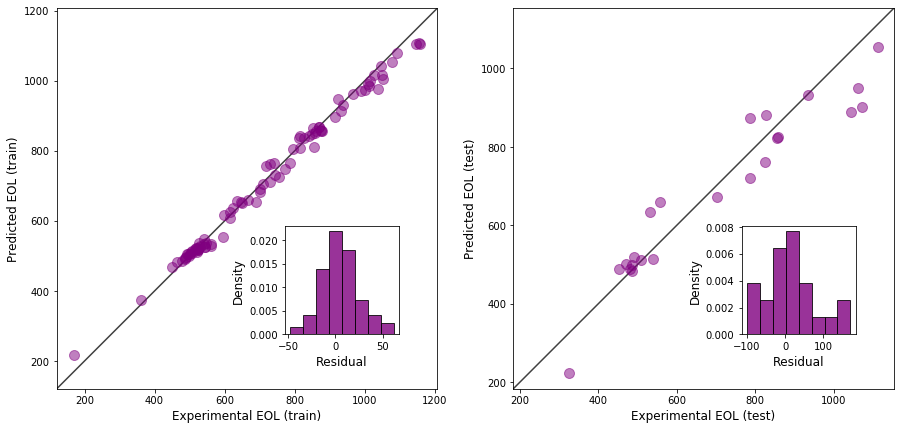

In [9]:
model, metrics = utils_models.fit_tree_based_regression(df=df,
                                                        test_size=test_size,
                                                        feature_selection=False,
                                                        scaling=False,
                                                        params=params,
                                                        plot=True,
                                                        fname='xgb_model')

### XGBoost regression with scaling but without feature selection

Tree-based regression has started...
Tree-based regression has ended after 1.56 seconds
------------------
Model metrics:
------------------
Train:
{'MAE': 16.301131523980036,
 'MAPE': 0.024247610714183555,
 'MSE': 451.35014027455406,
 'R2 score': 0.9901096658749142,
 'RMSE': 21.245002712980625}
Test:
{'MAE': 57.084064649498984,
 'MAPE': 0.08273140108519396,
 'MSE': 5466.779243898142,
 'R2 score': 0.9001028421182511,
 'RMSE': 73.93767134484385}


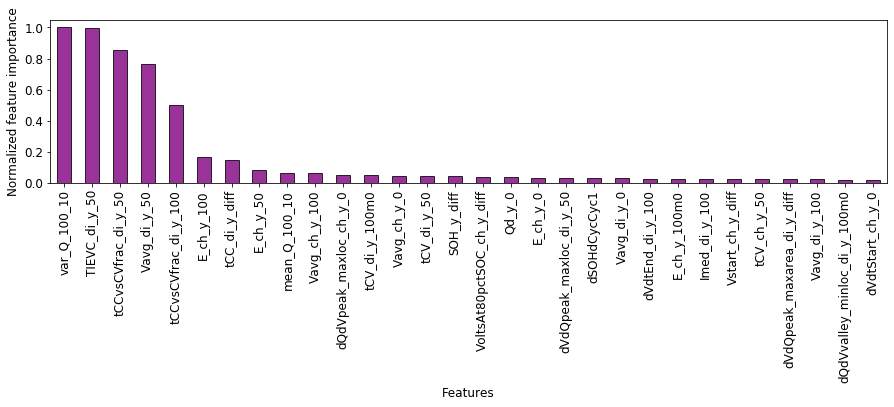

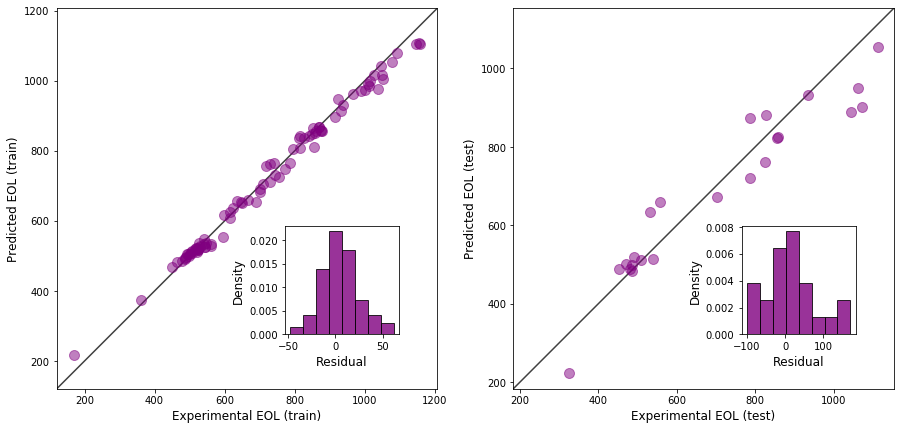

In [10]:
# call XGBoost regression function with scaling and feature selection
model, metrics  = utils_models.fit_tree_based_regression(df=df,
                                                        test_size=test_size,
                                                        feature_selection=False,
                                                        scaling=True,
                                                        params=params,
                                                        plot=True,
                                                        fname='xgb_model_scaled')

### XGBoost regression with feature selection with/without scaling for $k=0.5, 0.6, 0.7, 0.8, 0.9$

In [11]:
# define a list of k
k_list = [0.9, 0.8, 0.6, 0.5, 0.4, 0.3, 0.2]

In [12]:
# A function to fit model with several values of k and choosing whether to perform scaling or not
def k_effect_on_model(scaling, fname):

    metric_list = []

    for k in k_list:
        print('Fitting model with {} percent of features...'.format(int(k*100)))
        model, metrics = utils_models.fit_tree_based_regression(df=df,
                                                                test_size=test_size,
                                                                feature_selection=True,
                                                                scaling=scaling,
                                                                params=params,
                                                                plot=True,
                                                                fname=fname+str(int(k*100)),
                                                                k=k)

        metric_list.append(list(metrics[0].values()) + list(metrics[1].values()))

    metric_data = pd.DataFrame(data=np.array(metric_list), columns=[data + metric for data in ('Train_', 'Test_') for metric in metrics[0].keys()], index=np.array(k_list)*100)
    metric_data.index.name = 'Features used (%)'
    
    return metric_data

Fitting model with 90 percent of features...
25 features removed from a total of 244
Tree-based regression has started...
Tree-based regression has ended after 1.47 seconds
------------------
Model metrics:
------------------
Train:
{'MAE': 16.628944566514757,
 'MAPE': 0.024754524245084664,
 'MSE': 457.49030795948994,
 'R2 score': 0.9899751177612233,
 'RMSE': 21.389023071647987}
Test:
{'MAE': 57.48702737559443,
 'MAPE': 0.08312887660409149,
 'MSE': 5568.2962611206285,
 'R2 score': 0.8982477715099988,
 'RMSE': 74.62101755618606}


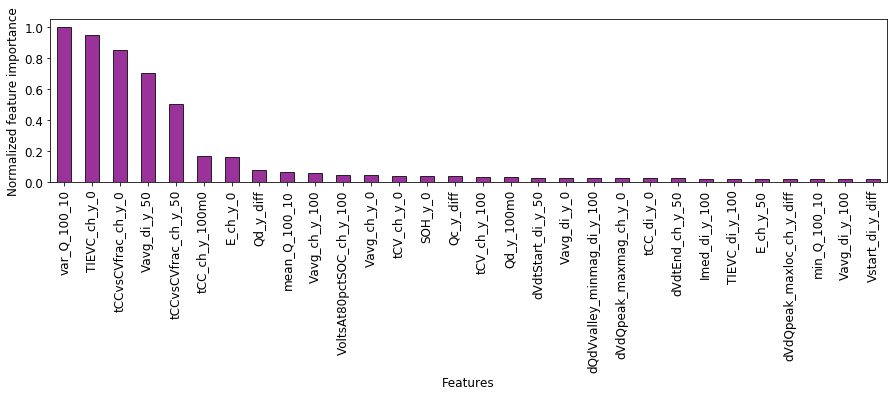

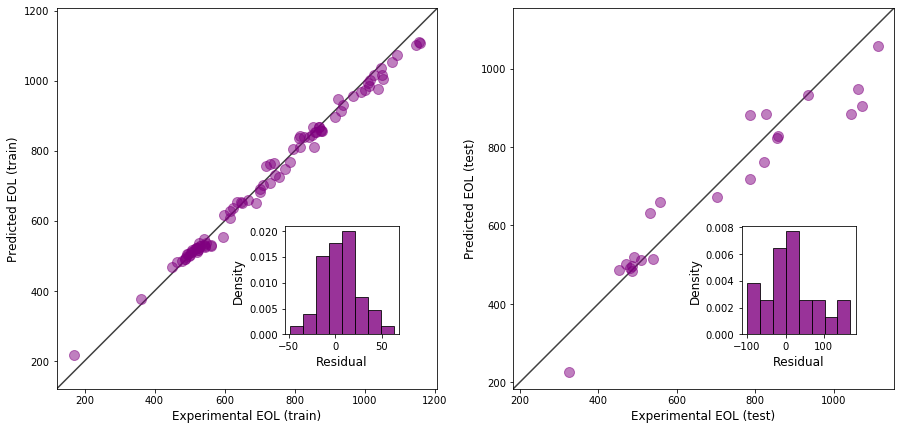

Fitting model with 80 percent of features...
49 features removed from a total of 244
Tree-based regression has started...
Tree-based regression has ended after 2.14 seconds
------------------
Model metrics:
------------------
Train:
{'MAE': 16.92577887641059,
 'MAPE': 0.024783067687193974,
 'MSE': 486.6610670552589,
 'R2 score': 0.9893359054770219,
 'RMSE': 22.060395895252174}
Test:
{'MAE': 52.63287419858186,
 'MAPE': 0.07713617664005507,
 'MSE': 4209.988306129159,
 'R2 score': 0.9230688038176913,
 'RMSE': 64.88442267701208}


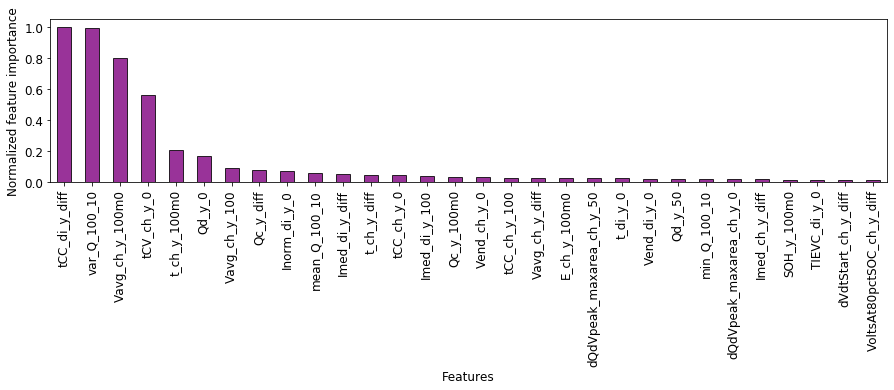

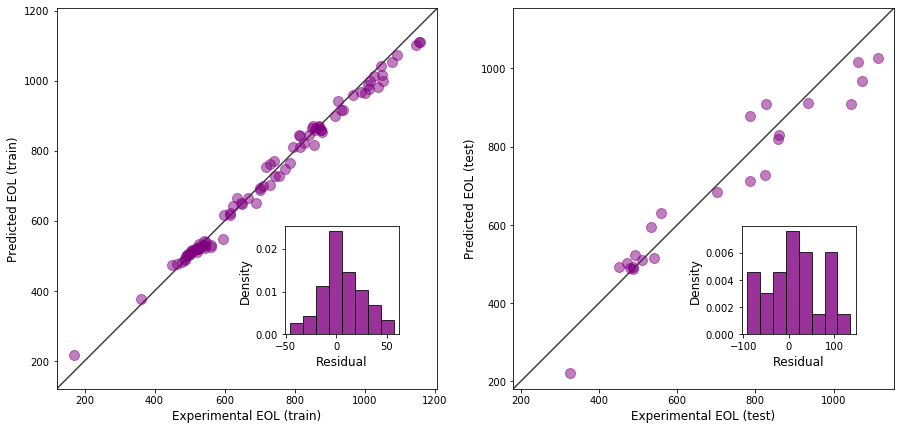

Fitting model with 60 percent of features...
98 features removed from a total of 244
Tree-based regression has started...
Tree-based regression has ended after 3.75 seconds
------------------
Model metrics:
------------------
Train:
{'MAE': 17.569081285264758,
 'MAPE': 0.025873629106479168,
 'MSE': 525.1386360997851,
 'R2 score': 0.9884927551593108,
 'RMSE': 22.915903562805134}
Test:
{'MAE': 48.874419502590015,
 'MAPE': 0.07280748535463726,
 'MSE': 4002.7409500376543,
 'R2 score': 0.9268559371421541,
 'RMSE': 63.267218605195964}


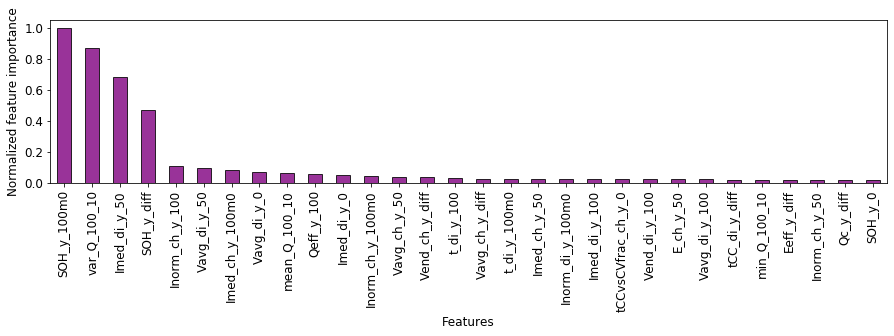

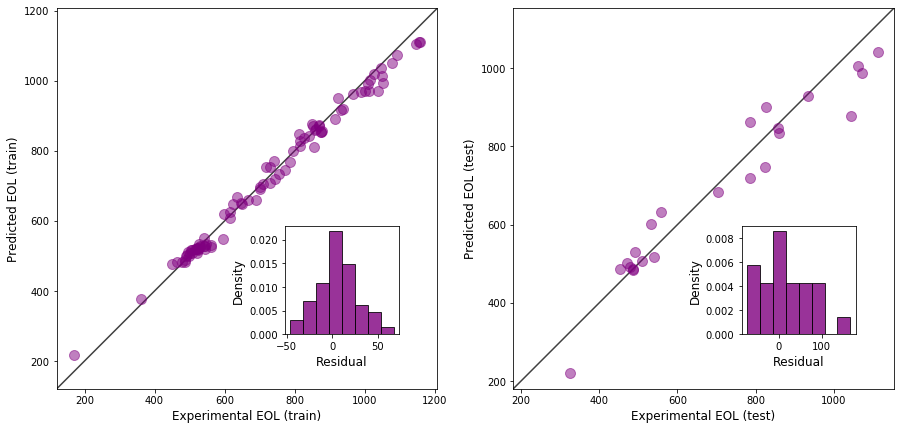

Fitting model with 50 percent of features...
122 features removed from a total of 244
Tree-based regression has started...
Tree-based regression has ended after 5.25 seconds
------------------
Model metrics:
------------------
Train:
{'MAE': 18.153170267740887,
 'MAPE': 0.02687420971173463,
 'MSE': 563.6487385704312,
 'R2 score': 0.9876488919439492,
 'RMSE': 23.741287635055333}
Test:
{'MAE': 50.32017915145211,
 'MAPE': 0.07320164063068567,
 'MSE': 4240.8336378319855,
 'R2 score': 0.9225051518329378,
 'RMSE': 65.12168331540568}


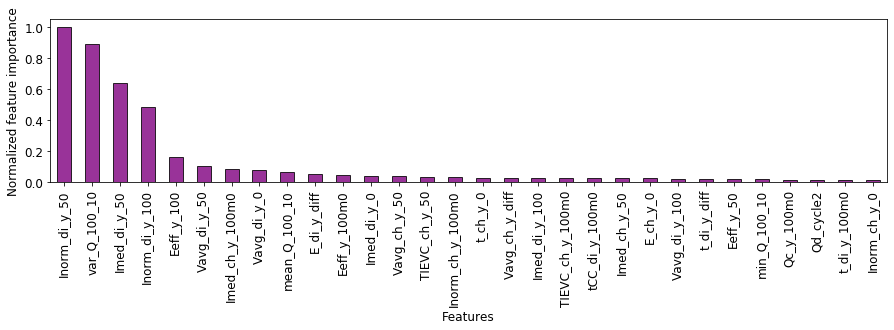

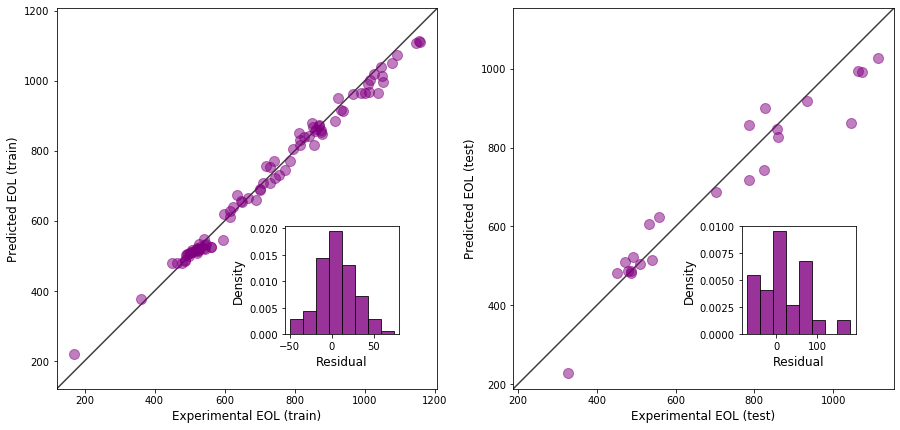

Fitting model with 40 percent of features...
147 features removed from a total of 244
Tree-based regression has started...
Tree-based regression has ended after 3.11 seconds
------------------
Model metrics:
------------------
Train:
{'MAE': 17.969859313964843,
 'MAPE': 0.02660581048099888,
 'MSE': 545.3920594393923,
 'R2 score': 0.9880489464482208,
 'RMSE': 23.353630540868636}
Test:
{'MAE': 49.33181497325068,
 'MAPE': 0.07243975621986913,
 'MSE': 4116.432845712235,
 'R2 score': 0.9247783889651803,
 'RMSE': 64.15943302206024}


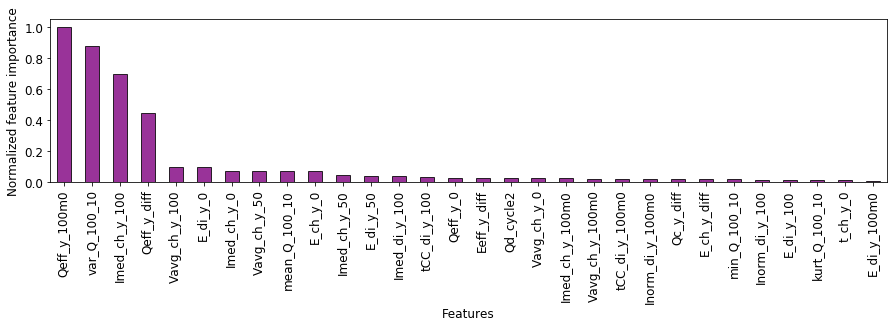

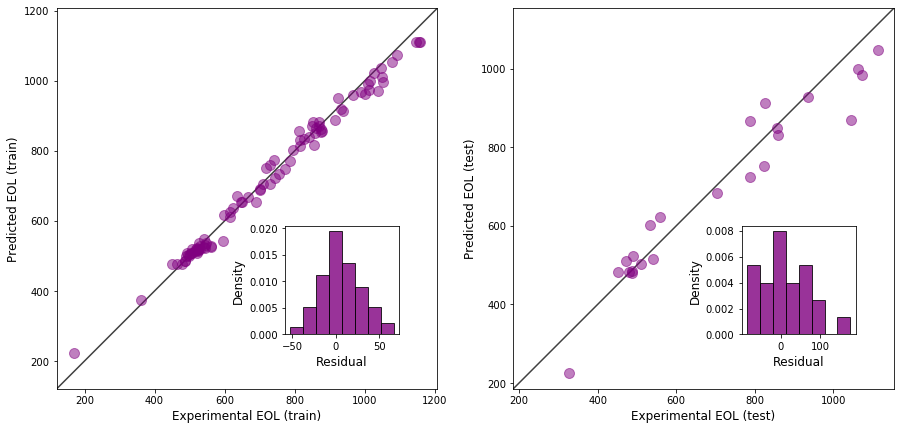

Fitting model with 30 percent of features...
171 features removed from a total of 244
Tree-based regression has started...
Tree-based regression has ended after 3.49 seconds
------------------
Model metrics:
------------------
Train:
{'MAE': 18.433926222059462,
 'MAPE': 0.027560665499953573,
 'MSE': 573.3878544542964,
 'R2 score': 0.9874354808876997,
 'RMSE': 23.945518462841775}
Test:
{'MAE': 48.41041166886039,
 'MAPE': 0.07106732199100443,
 'MSE': 4040.7439596675763,
 'R2 score': 0.9261614893725245,
 'RMSE': 63.56684638762235}


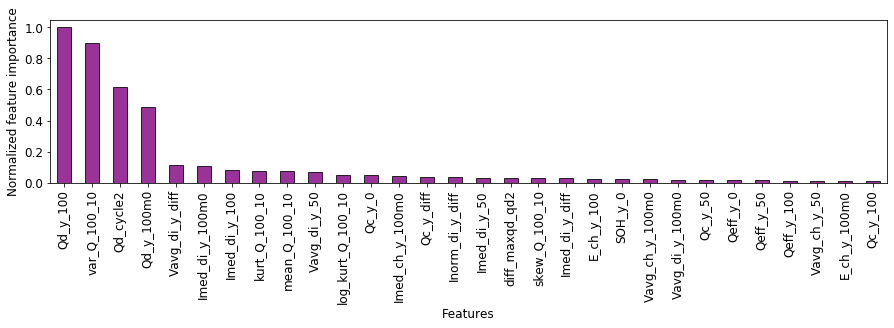

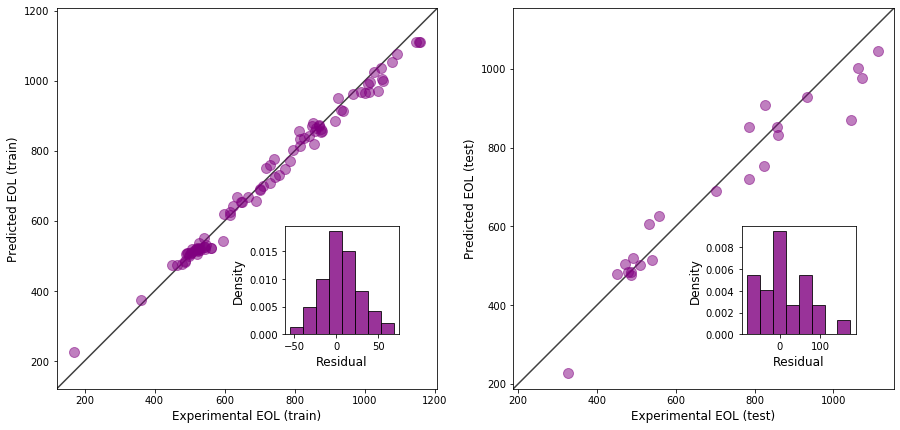

Fitting model with 20 percent of features...
196 features removed from a total of 244
Tree-based regression has started...
Tree-based regression has ended after 3.74 seconds
------------------
Model metrics:
------------------
Train:
{'MAE': 21.69140150282118,
 'MAPE': 0.03197760436549788,
 'MSE': 808.0951535493135,
 'R2 score': 0.9822923926231562,
 'RMSE': 28.427014502921573}
Test:
{'MAE': 46.08482095469599,
 'MAPE': 0.06743870674421414,
 'MSE': 4135.561564722919,
 'R2 score': 0.9244288404325193,
 'RMSE': 64.30833200078291}


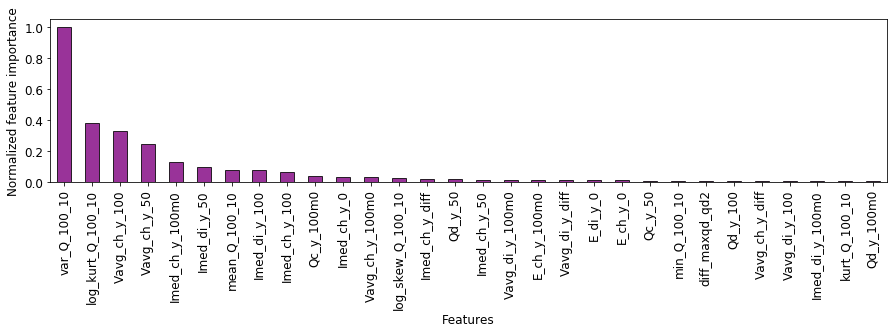

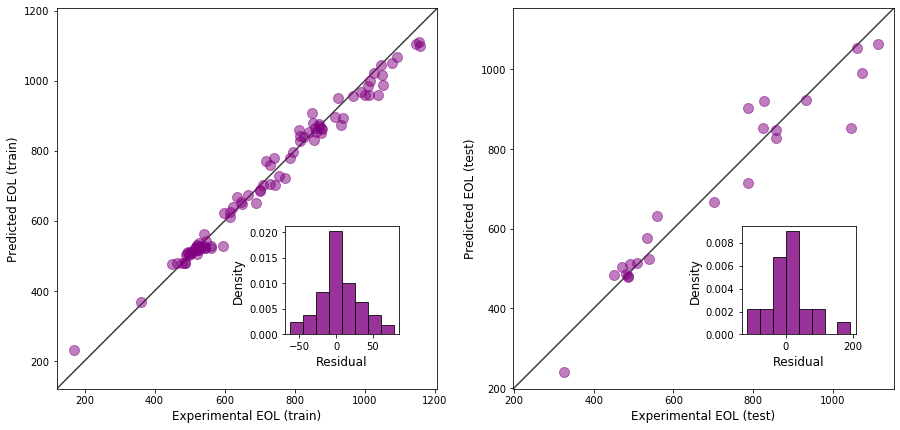

,Train_MAE,Train_MAPE,Train_MSE,Train_RMSE,Train_R2 score,Test_MAE,Test_MAPE,Test_MSE,Test_RMSE,Test_R2 score
Features used (%),,,,,,,,,,
90.0,16.628945,0.024755,457.490308,21.389023,0.989975,57.487027,0.083129,5568.296261,74.621018,0.898248
80.0,16.925779,0.024783,486.661067,22.060396,0.989336,52.632874,0.077136,4209.988306,64.884423,0.923069
60.0,17.569081,0.025874,525.138636,22.915904,0.988493,48.874420,0.072807,4002.740950,63.267219,0.926856
50.0,18.153170,0.026874,563.648739,23.741288,0.987649,50.320179,0.073202,4240.833638,65.121683,0.922505
40.0,17.969859,0.026606,545.392059,23.353631,0.988049,49.331815,0.072440,4116.432846,64.159433,0.924778
30.0,18.433926,0.027561,573.387854,23.945518,0.987435,48.410412,0.071067,4040.743960,63.566846,0.926161
20.0,21.691402,0.031978,808.095154,28.427015,0.982292,46.084821,0.067439,4135.561565,64.308332,0.924429


In [13]:
# call XGBoost regression function with feature selection using different k but without scaling
k_effect_on_model(scaling=False, fname='xgb_model_ftselection_k_')

Fitting model with 90 percent of features...
25 features removed from a total of 244
Tree-based regression has started...
Tree-based regression has ended after 4.0 seconds
------------------
Model metrics:
------------------
Train:
{'MAE': 16.628944566514757,
 'MAPE': 0.024754524245084664,
 'MSE': 457.49030795948994,
 'R2 score': 0.9899751177612233,
 'RMSE': 21.389023071647987}
Test:
{'MAE': 57.48702737559443,
 'MAPE': 0.08312887660409149,
 'MSE': 5568.2962611206285,
 'R2 score': 0.8982477715099988,
 'RMSE': 74.62101755618606}


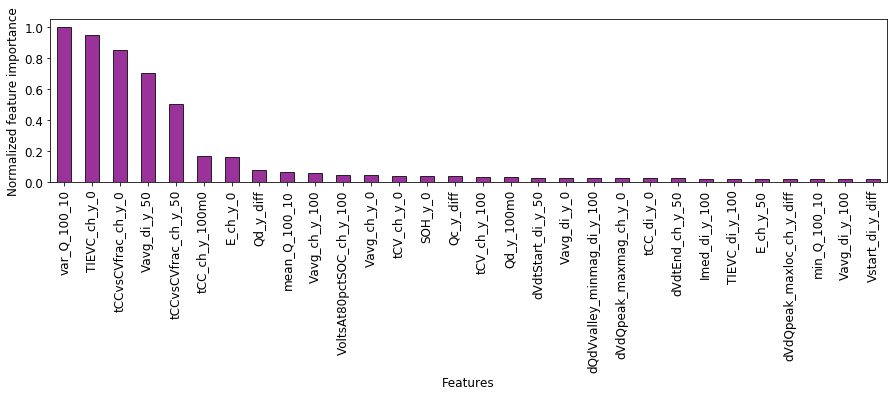

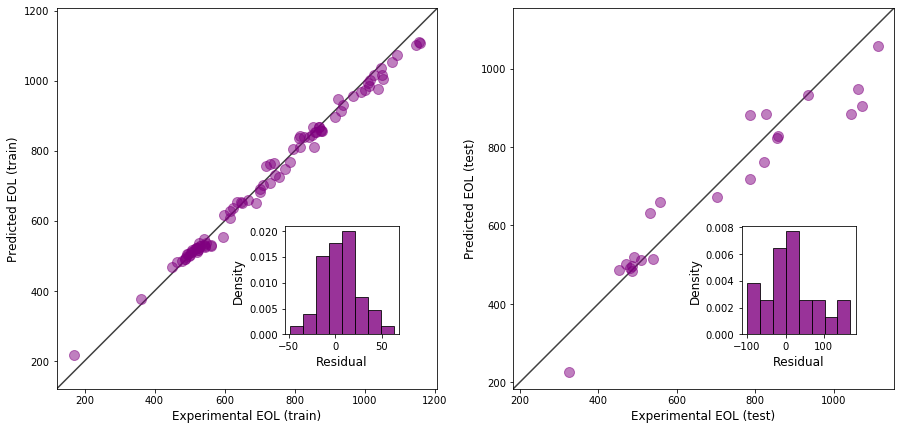

Fitting model with 80 percent of features...
49 features removed from a total of 244
Tree-based regression has started...
Tree-based regression has ended after 2.46 seconds
------------------
Model metrics:
------------------
Train:
{'MAE': 16.92577887641059,
 'MAPE': 0.024783067687193974,
 'MSE': 486.6610670552589,
 'R2 score': 0.9893359054770219,
 'RMSE': 22.060395895252174}
Test:
{'MAE': 52.63287419858186,
 'MAPE': 0.07713617664005507,
 'MSE': 4209.988306129159,
 'R2 score': 0.9230688038176913,
 'RMSE': 64.88442267701208}


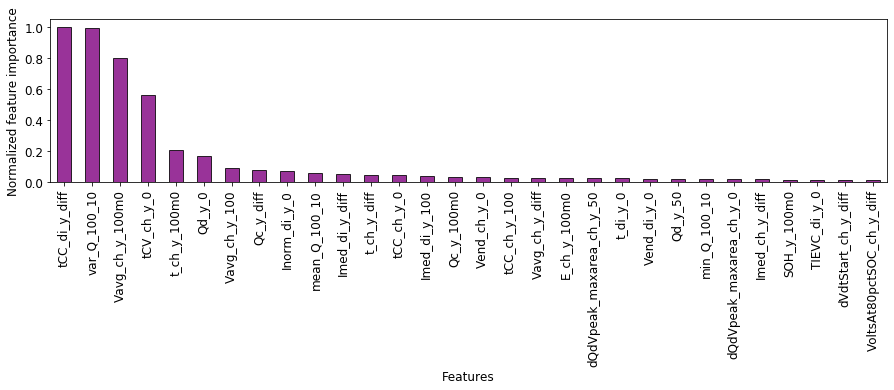

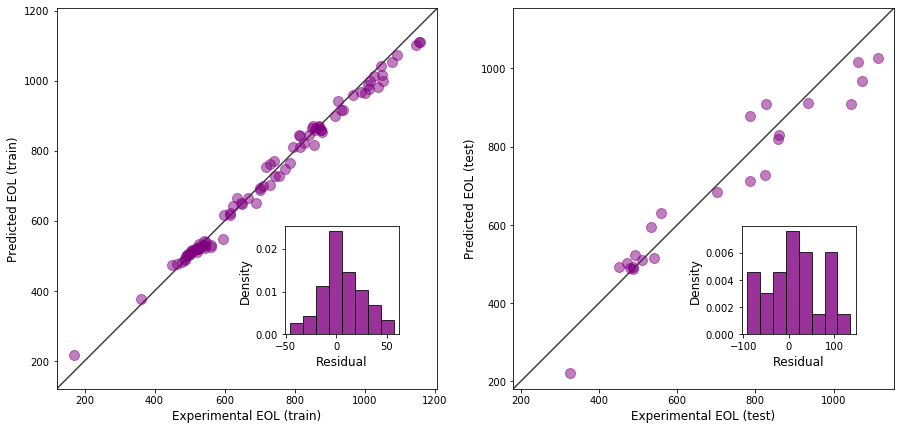

Fitting model with 60 percent of features...
98 features removed from a total of 244
Tree-based regression has started...
Tree-based regression has ended after 2.42 seconds
------------------
Model metrics:
------------------
Train:
{'MAE': 17.569081285264758,
 'MAPE': 0.025873629106479168,
 'MSE': 525.1386360997851,
 'R2 score': 0.9884927551593108,
 'RMSE': 22.915903562805134}
Test:
{'MAE': 48.874419502590015,
 'MAPE': 0.07280748535463726,
 'MSE': 4002.7409500376543,
 'R2 score': 0.9268559371421541,
 'RMSE': 63.267218605195964}


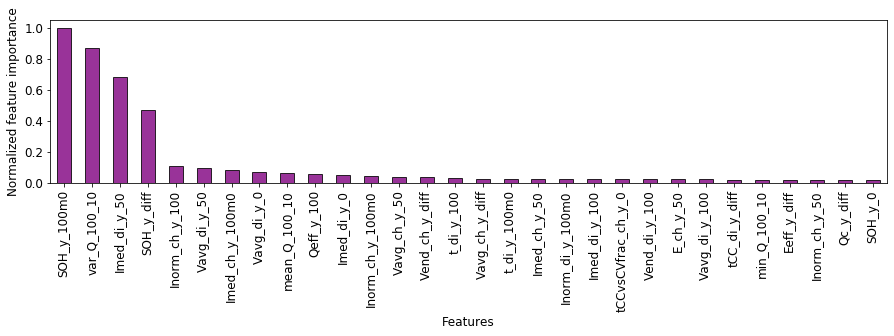

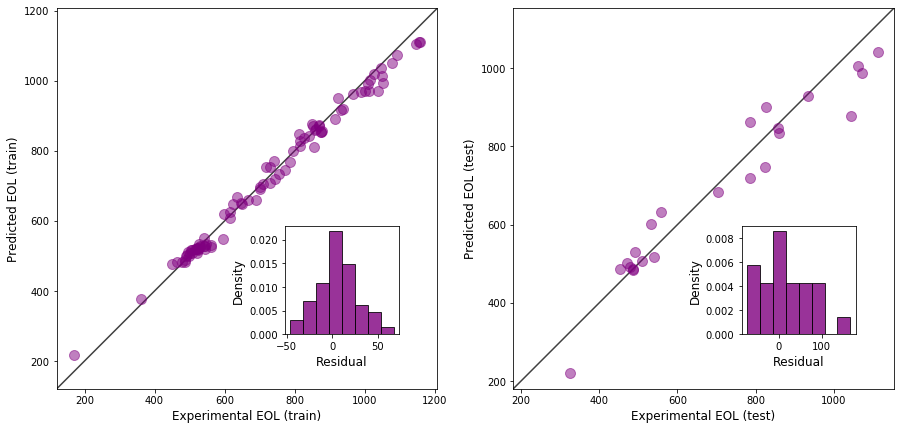

Fitting model with 50 percent of features...
122 features removed from a total of 244
Tree-based regression has started...
Tree-based regression has ended after 2.61 seconds
------------------
Model metrics:
------------------
Train:
{'MAE': 18.153170267740887,
 'MAPE': 0.02687420971173463,
 'MSE': 563.6487385704312,
 'R2 score': 0.9876488919439492,
 'RMSE': 23.741287635055333}
Test:
{'MAE': 50.32017915145211,
 'MAPE': 0.07320164063068567,
 'MSE': 4240.8336378319855,
 'R2 score': 0.9225051518329378,
 'RMSE': 65.12168331540568}


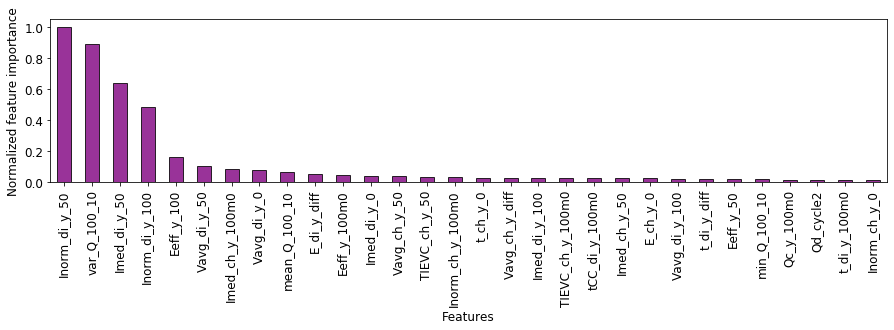

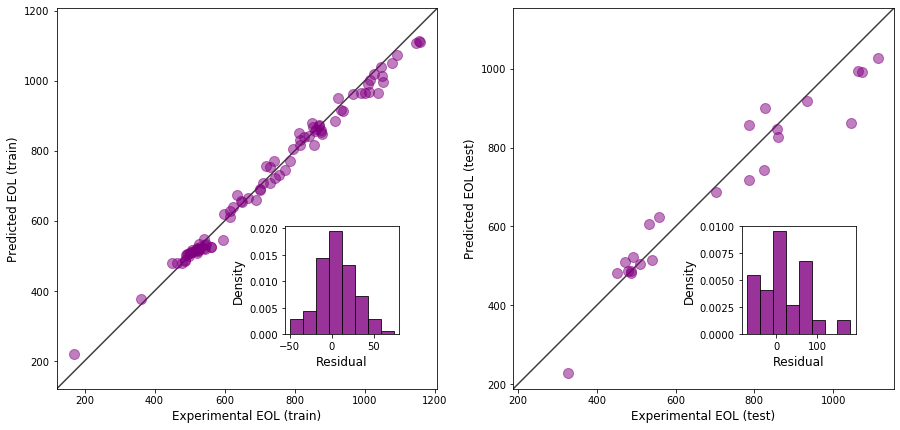

Fitting model with 40 percent of features...
147 features removed from a total of 244
Tree-based regression has started...
Tree-based regression has ended after 3.59 seconds
------------------
Model metrics:
------------------
Train:
{'MAE': 17.969859313964843,
 'MAPE': 0.02660581048099888,
 'MSE': 545.3920594393923,
 'R2 score': 0.9880489464482208,
 'RMSE': 23.353630540868636}
Test:
{'MAE': 49.33181497325068,
 'MAPE': 0.07243975621986913,
 'MSE': 4116.432845712235,
 'R2 score': 0.9247783889651803,
 'RMSE': 64.15943302206024}


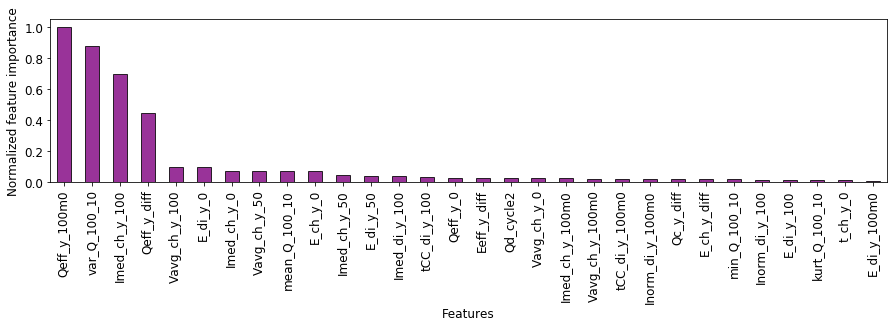

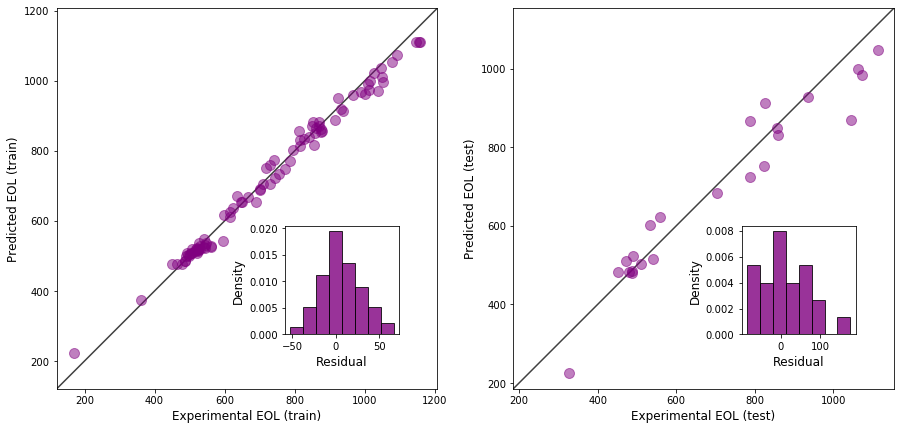

Fitting model with 30 percent of features...
171 features removed from a total of 244
Tree-based regression has started...
Tree-based regression has ended after 3.11 seconds
------------------
Model metrics:
------------------
Train:
{'MAE': 18.433926222059462,
 'MAPE': 0.027560665499953573,
 'MSE': 573.3878544542964,
 'R2 score': 0.9874354808876997,
 'RMSE': 23.945518462841775}
Test:
{'MAE': 48.41041166886039,
 'MAPE': 0.07106732199100443,
 'MSE': 4040.7439596675763,
 'R2 score': 0.9261614893725245,
 'RMSE': 63.56684638762235}


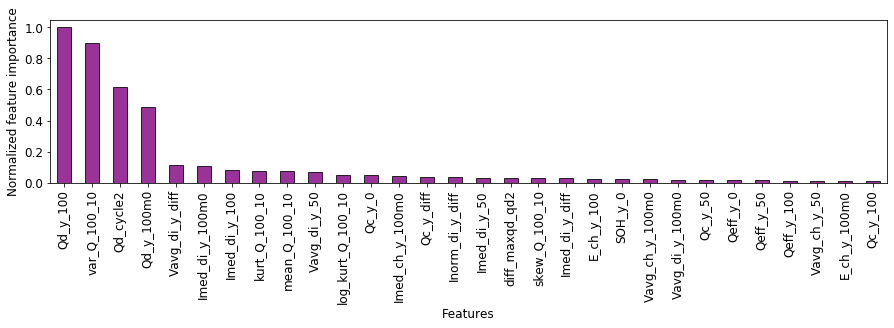

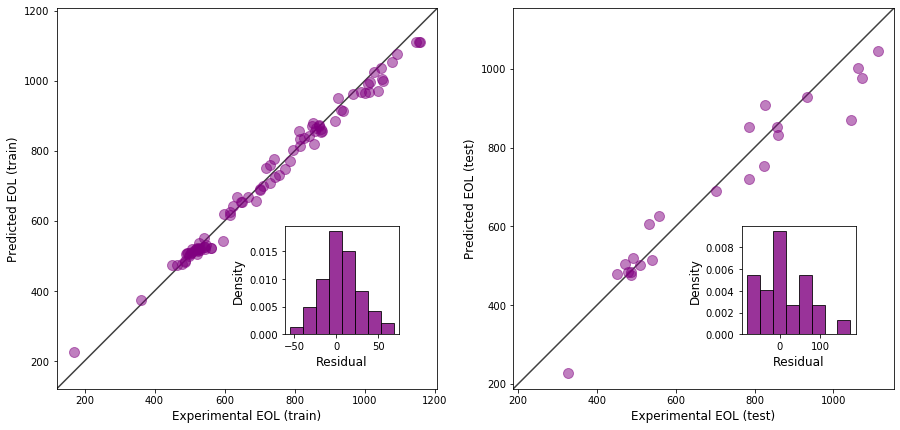

Fitting model with 20 percent of features...
196 features removed from a total of 244
Tree-based regression has started...
Tree-based regression has ended after 2.87 seconds
------------------
Model metrics:
------------------
Train:
{'MAE': 21.69140150282118,
 'MAPE': 0.03197760436549788,
 'MSE': 808.0951535493135,
 'R2 score': 0.9822923926231562,
 'RMSE': 28.427014502921573}
Test:
{'MAE': 46.08482095469599,
 'MAPE': 0.06743870674421414,
 'MSE': 4135.561564722919,
 'R2 score': 0.9244288404325193,
 'RMSE': 64.30833200078291}


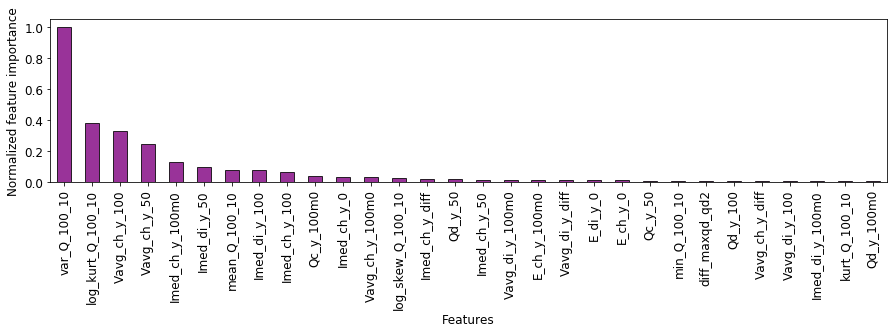

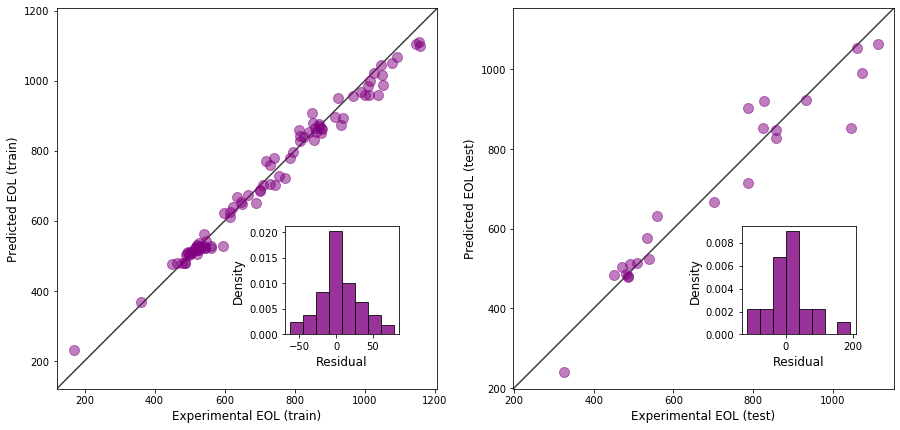

,Train_MAE,Train_MAPE,Train_MSE,Train_RMSE,Train_R2 score,Test_MAE,Test_MAPE,Test_MSE,Test_RMSE,Test_R2 score
Features used (%),,,,,,,,,,
90.0,16.628945,0.024755,457.490308,21.389023,0.989975,57.487027,0.083129,5568.296261,74.621018,0.898248
80.0,16.925779,0.024783,486.661067,22.060396,0.989336,52.632874,0.077136,4209.988306,64.884423,0.923069
60.0,17.569081,0.025874,525.138636,22.915904,0.988493,48.874420,0.072807,4002.740950,63.267219,0.926856
50.0,18.153170,0.026874,563.648739,23.741288,0.987649,50.320179,0.073202,4240.833638,65.121683,0.922505
40.0,17.969859,0.026606,545.392059,23.353631,0.988049,49.331815,0.072440,4116.432846,64.159433,0.924778
30.0,18.433926,0.027561,573.387854,23.945518,0.987435,48.410412,0.071067,4040.743960,63.566846,0.926161
20.0,21.691402,0.031978,808.095154,28.427015,0.982292,46.084821,0.067439,4135.561565,64.308332,0.924429


In [14]:
# call XGBoost regression function with feature selection and scaling using different k
k_effect_on_model(scaling=True, fname='xgb_model_ftselection_scaled_k_')

### Perform $k$-Fold Repeated Cross-validation on the best trial and error model

In [15]:
# the best model here uses less features and excelled in MAPE: feature_selection=True, k=0.3
model = XGBRegressor(**params)
best_model_cross_val_scores = utils_models.repeated_kfold_cross_validation(model=model,
                                                                           df=df,
                                                                           n_splits=3,
                                                                           n_repeats=3,
                                                                           feature_selection=True,
                                                                           scaling=False,
                                                                           k=0.3)

best_model_cross_val_scores

171 features removed from a total of 244


{'test_MAE': (52.91930847746775, 8.150487668764546),
 'test_MAPE': (0.08203377170073196, 0.02423439756721947),
 'test_MSE': (5210.205378341654, 1796.0103542888178),
 'test_R2 score': (0.8902348125349708, 0.03287729382403453)}

### Hyper-parameter tuning 

In [16]:
estimator = XGBRegressor()
param_grid = {"n_estimators": [100, 200, 300, 400, 500],
                    "max_depth": [2, 3, 4, 5],
                    "min_samples_split": [2, 3, 4, 5],
                    "learning_rate": [0.01, 0.1, 1.0]}
                    
scoring = 'neg_mean_absolute_percentage_error'
cv = 3

# for the model without feature selection
best_param_all, _ = utils_models.hyperparameter_tuning(df, estimator, param_grid, scoring, cv, feature_selection=False, k=None)
print(best_param_all)

{'learning_rate': 0.1, 'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 100}


In [17]:
# for the model with feature selection
best_param_selected, _ = utils_models.hyperparameter_tuning(df, estimator, param_grid, scoring, cv, feature_selection=True, k=0.3)
print(best_param_selected)

171 features removed from a total of 244
{'learning_rate': 0.1, 'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 100}


### Use the best hyper-parameter to rebuild the models and carry out repeated $k$-fold cross-validation

Tree-based regression has started...
Tree-based regression has ended after 0.64 seconds
------------------
Model metrics:
------------------
Train:
{'MAE': 5.254085625542535,
 'MAPE': 0.008039565345710032,
 'MSE': 45.23558538174257,
 'R2 score': 0.9990087627900213,
 'RMSE': 6.725740508058764}
Test:
{'MAE': 54.589686518130094,
 'MAPE': 0.08520321828309194,
 'MSE': 4849.680598625033,
 'R2 score': 0.9113793905291402,
 'RMSE': 69.63964817993434}


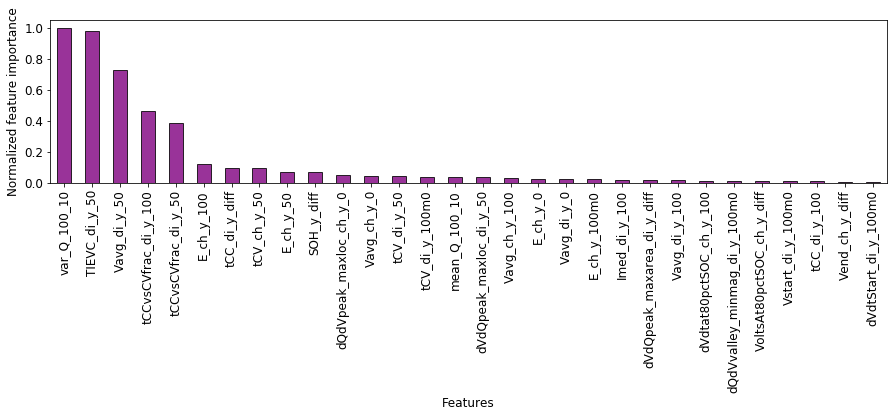

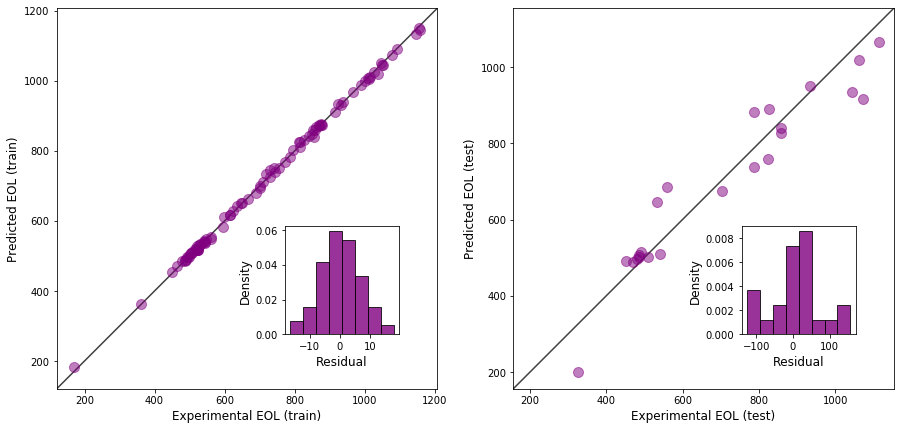

In [18]:
# for the model using all the features 
best_model_all, metrics_all = utils_models.fit_tree_based_regression(df=df,
                                                                    test_size=test_size,
                                                                    feature_selection=False,
                                                                    scaling=False,
                                                                    params=best_param_all,
                                                                    plot=True,
                                                                    fname='best_all_features_xgb_model')


171 features removed from a total of 244
Tree-based regression has started...
Tree-based regression has ended after 0.65 seconds
------------------
Model metrics:
------------------
Train:
{'MAE': 8.709761895073784,
 'MAPE': 0.013407947825114664,
 'MSE': 130.71554215497648,
 'R2 score': 0.9971356597198174,
 'RMSE': 11.43308979038372}
Test:
{'MAE': 46.328960252844766,
 'MAPE': 0.07052161040735698,
 'MSE': 3910.247060976528,
 'R2 score': 0.9285461236718094,
 'RMSE': 62.53196831202843}


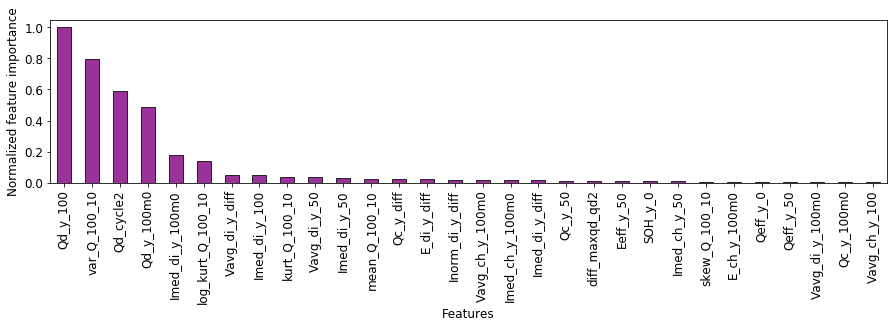

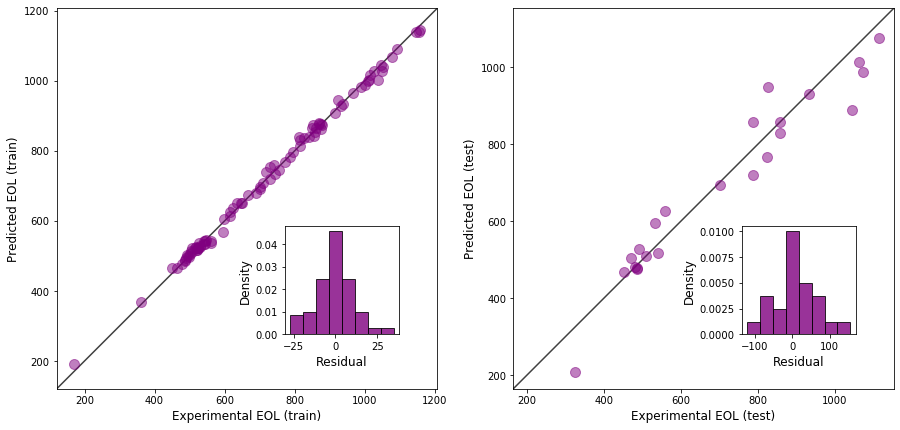

In [19]:
# for the model using selected features 
best_model_selected, metrics_selected = utils_models.fit_tree_based_regression(df=df,
                                                                                test_size=test_size,
                                                                                feature_selection=True,
                                                                                scaling=False,
                                                                                params=best_param_selected,
                                                                                plot=True,
                                                                                fname='best_selected_features_xgb_model',
                                                                                k=0.3)

In [20]:
# Repeated k-fold cross-validation for the model obtained from grid search and using all features
model = XGBRegressor(**best_param_all)
utils_models.repeated_kfold_cross_validation(model=model,
                                            df=df,
                                            n_splits=3,
                                            n_repeats=3,
                                            feature_selection=False,
                                            scaling=False)



{'test_MAE': (52.910054425860125, 7.7951932290883965),
 'test_MAPE': (0.0832413255961027, 0.02393377785913858),
 'test_MSE': (5202.452510223169, 1809.1946620006763),
 'test_R2 score': (0.8902775088596927, 0.03325813007545427)}

In [21]:
# Repeated k-fold cross-validation for the model obtained from grid search and using selected features
model = XGBRegressor(**best_param_selected)
utils_models.repeated_kfold_cross_validation(model=model,
                                            df=df,
                                            n_splits=3,
                                            n_repeats=3,
                                            feature_selection=True,
                                            scaling=False,
                                            k=0.3)

171 features removed from a total of 244


{'test_MAE': (51.78171913601577, 7.914258200728915),
 'test_MAPE': (0.0822095850498564, 0.02474757190736925),
 'test_MSE': (5085.055155179714, 1728.4666567597358),
 'test_R2 score': (0.8927747914247307, 0.03134045455296663)}